#### Chain Of Thoughts With RAG
What is Chain-of-Thought (CoT) in RAG?

CoT reasoning breaks down a complex question into intermediate steps, and allows retrieval + reflection at each step before answering.

User Query
   ↓
- Step 1: Decompose question → sub-steps (Reason)
- Step 2: Retrieve docs per step (Act)
- Step 3: Combine context (Observe)
- Step 4: Final answer generation (Reflect)

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END


In [2]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

✓ Gemini model initialized for reranking


/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# -------------------------------
# 1. Prepare Vectorstore
# -------------------------------
docs = TextLoader("research_notes.txt",encoding="utf-8").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
embedding = embedding_model
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [5]:
# -------------------------------
# 2. LangGraph State Definition
# -------------------------------
class RAGCoTState(BaseModel):
    question: str
    sub_steps: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [ ]:
# -------------------------------
# 3. Nodes
# -------------------------------

# a. Plan sub-questions
def plan_steps(state:RAGCoTState)->RAGCoTState:
    prompt=f"Break the question into 2-3 reasoning steps: \n\n {state.question}"
    result=llm.invoke(prompt).content
    subqs=[line.strip("- ") for line in result.split("\n") if line.strip()]

    return state.model_copy(update={"sub_steps":subqs}) 


In [7]:
# b. Retrieve for each step
def retrieve_per_step(state:RAGCoTState)-> RAGCoTState:
    all_docs=[]
    for sub in state.sub_steps:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={"retrieved_docs": all_docs})

In [8]:
# b. Retrieve for each step
def retrieve_per_step(state:RAGCoTState)-> RAGCoTState:
    all_docs=[]
    for sub in state.sub_steps:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={"retrieved_docs": all_docs})

In [9]:
# c. Generate Final Answer
def generate_answer(state: RAGCoTState) -> RAGCoTState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
You are answering a complex question using reasoning and retrieved documents.

Question: {state.question}

Relevant Information:
{context}

Now synthesize a well-reasoned final answer.
"""
    result = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": result})

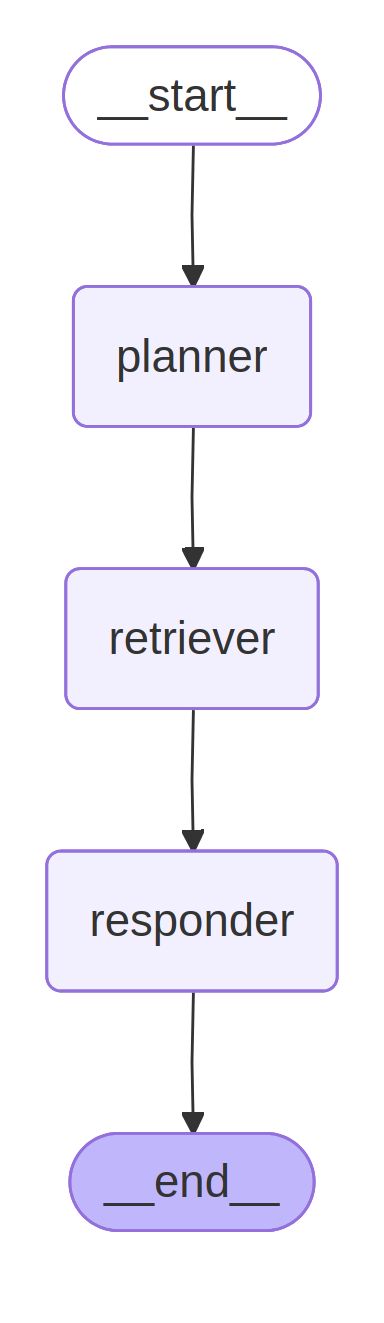

In [10]:
# -------------------------------
# 4. LangGraph Graph
# -------------------------------
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()


builder = StateGraph(RAGCoTState)
builder.add_node("planner", plan_steps)
builder.add_node("retriever", retrieve_per_step)
builder.add_node("responder", generate_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [11]:
# -------------------------------
# 5. Run CoT RAG Agent
# -------------------------------
if __name__ == "__main__":
    query = "what are the additional experiments in Transformer evaluation?"
    state = RAGCoTState(question=query)
    final = graph.invoke(state)

    print("\n🪜 Reasoning Steps:", final["sub_steps"])
    print("\n✅ Final Answer:\n", final["answer"])


🪜 Reasoning Steps: ['Here\'s a breakdown of the question "What are the additional experiments in Transformer evaluation?" into reasoning steps:', '1.  **Understand the Baseline:** What are the *standard* or *common* evaluation methods for Transformers? This includes things like accuracy on benchmark datasets (e.g., GLUE, SQuAD), BLEU score for translation, perplexity for language modeling, etc.  We need to know what\'s already considered "normal" to identify what\'s "additional."', '2.  **Identify Limitations of Standard Evaluation:** What are the *shortcomings* of these standard evaluation methods? Do they fully capture the capabilities and limitations of Transformers?  For example, do they adequately assess robustness, fairness, reasoning ability, or generalization to out-of-distribution data?', '3.  **Explore "Additional" Experiments:** Based on the limitations identified, what *new* or *less common* experiments are being developed and used to provide a more comprehensive evaluatio